infrastrcutre = colums 28 - -4
converted infrastucture into ints of 0s and 1s

one hot encoded

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize


In [3]:
accident_data = pd.read_csv("ignorefolder/cleaned_US_Accidents.csv", index_col=0)
print(accident_data.shape)

(988706, 24)


In [4]:
print(accident_data.columns)

Index(['Severity', 'State', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'],
      dtype='object')


In [5]:
county_data = gpd.read_file("zip:county_data.gpkg.zip")
county_data.to_crs("4269")

drop_states = ['02', '15', '60', '66', '69', '72', '78']
mask = county_data['STATEFP'].isin(drop_states)
state_data = county_data[~mask]
state_data = state_data.dissolve(by="STATEFP")


In [6]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

state_to_abbrev = {
    "alabama": "AL",
    "alaska": "AK",
    "arizona": "AZ",
    "arkansas": "AR",
    "american samoa": "AS",
    "california": "CA",
    "colorado": "CO",
    "connecticut": "CT",
    "delaware": "DE",
    "district of columbia": "DC",
    "florida": "FL",
    "georgia": "GA",
    "guam": "GU",
    "hawaii": "HI",
    "idaho": "ID",
    "illinois": "IL",
    "indiana": "IN",
    "iowa": "IA",
    "kansas": "KS",
    "kentucky": "KY",
    "louisiana": "LA",
    "maine": "ME",
    "maryland": "MD",
    "massachusetts": "MA",
    "michigan": "MI",
    "minnesota": "MN",
    "mississippi": "MS",
    "missouri": "MO",
    "montana": "MT",
    "nebraska": "NE",
    "nevada": "NV",
    "new hampshire": "NH",
    "new jersey": "NJ",
    "new mexico": "NM",
    "new york": "NY",
    "north carolina": "NC",
    "north dakota": "ND",
    "northern mariana islands": "MP",
    "ohio": "OH",
    "oklahoma": "OK",
    "oregon": "OR",
    "pennsylvania": "PA",
    "puerto rico": "PR",
    "rhode island": "RI",
    "south carolina": "SC",
    "south dakota": "SD",
    "tennessee": "TN",
    "texas": "TX",
    "trust territories": "TT",
    "utah": "UT",
    "vermont": "VT",
    "virginia": "VA",
    "virgin islands": "VI",
    "washington": "WA",
    "west virginia": "WV",
    "wisconsin": "WI",
    "wyoming": "WY"
}

accident_data['STATEFP'] = accident_data['State'].map(state_codes)

### Loading in population data for per capita calculations

In [7]:
population = pd.read_excel("ignorefolder/population.xlsx")

population = (population
    .drop(columns="Unnamed: 1")
    .iloc[8:, [0, 5]]
    .rename(columns= {population.columns[0]: "Geographic Area", population.columns[6]: "2024"})
    .reset_index(drop=True)
    .dropna()
)
population["Geographic Area"] = population["Geographic Area"].str.lstrip(".").str.lower()
#dropping puerto rico
population = population.drop(index=52)
population["State"] = population["Geographic Area"].map(state_to_abbrev)
population["STATEFP"] = population["State"].map(state_codes)

### Accidents by States

In [8]:
counts_by_state = (
    accident_data
    .groupby('STATEFP')[['State']]
    .count()
    .reset_index()
    .rename(columns={"State": "counts"})
)

# make sure population is numeric
population['2024'] = population['2024'].astype(float)

# merge in population
counts_by_state = counts_by_state.merge(
    population[['STATEFP', '2024']],
    on='STATEFP',
    how='left'
)

# compute accidents per 100,000 people
counts_by_state['per100k'] = counts_by_state['counts'] / counts_by_state['2024'] * 100_000

In [9]:
geographic_data = gpd.GeoDataFrame(counts_by_state.merge(state_data, on='STATEFP'), geometry='geometry')

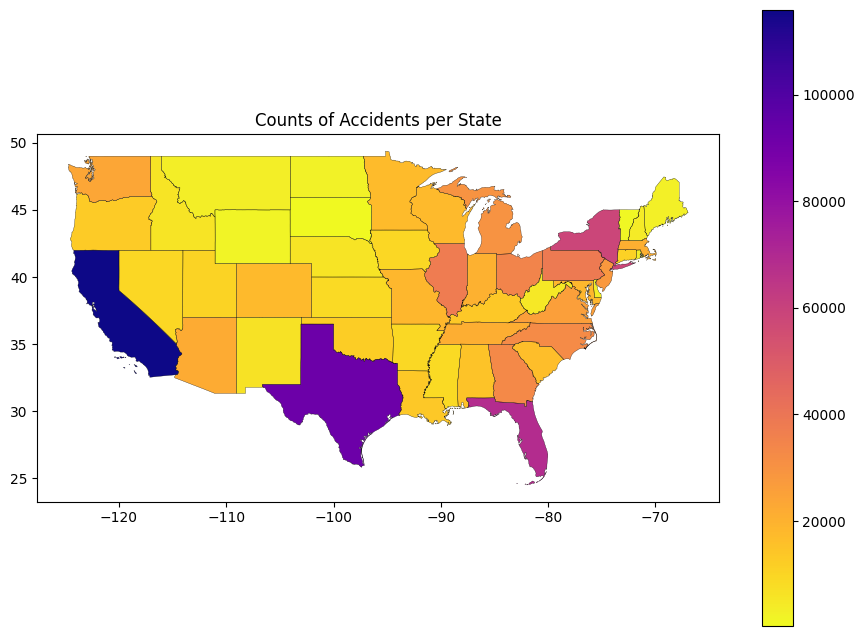

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,8))
state_data.to_crs("5071")
state_data.boundary.plot(linewidth=0.2, color='black', ax=ax)
geographic_data.plot(column='counts', legend=True, cmap='plasma_r', ax=ax)
plt.title("Counts of Accidents per State")
plt.axis("off")
plt.savefig("figures/accidents_per_state")

KeyError: 'per100k'

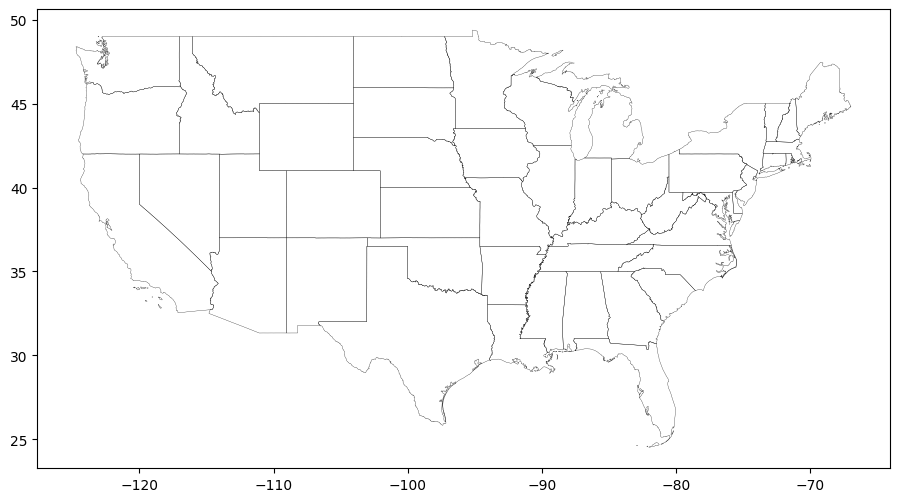

In [22]:
fig, ax = plt.subplots(1, figsize=(11,8))
state_data.to_crs("5071")
state_data.boundary.plot(linewidth=0.2, color='black', ax=ax)
geographic_data.plot(column='per100k', legend=True, cmap='plasma_r', ax=ax)
plt.title("Counts of Accidents per 100k")
plt.axis("off")
plt.savefig("figures/accidents_per100k")

### Infrastructure by States

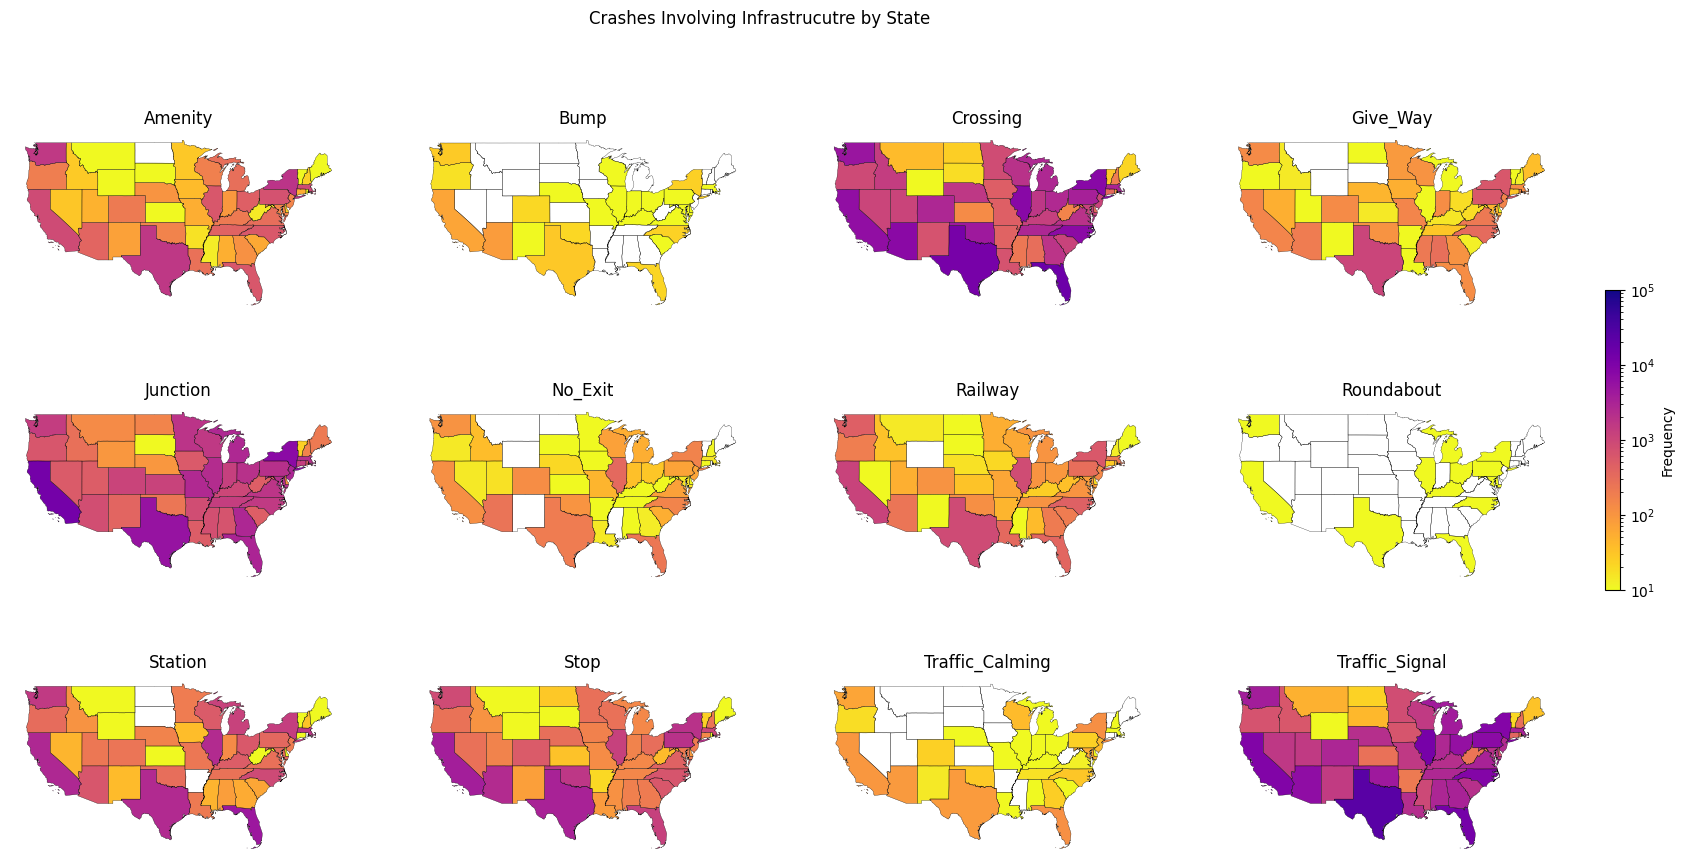

In [21]:
infrastructure = ["Amenity", 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

fig , axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.ravel()
norm = Normalize(vmin=0, vmax=100000)
norm = LogNorm(vmin=1e1, vmax=1e5)

maxes = []
mins = []

for i, feature in enumerate(infrastructure):
    mask = accident_data[feature] == True
    filtered = accident_data[mask]
    counts_by_state = filtered.groupby("STATEFP")[feature].count().reset_index().rename(columns={feature: "counts"})
    maxes.append(counts_by_state.max())



# Colormap
for i, feature in enumerate(infrastructure):
    
    mask = accident_data[feature] == True
    filtered = accident_data[mask]

    counts_by_state = filtered.groupby("STATEFP")[feature].count().reset_index().rename(columns={feature: "counts"})
    counts_by_state = counts_by_state.merge(population, how="left", on="STATEFP")

    counts_by_state["percapita"] = counts_by_state["counts"] / 1
    geographic_data = gpd.GeoDataFrame(counts_by_state.merge(state_data, on='STATEFP'), geometry='geometry')

    state_data.to_crs("5071")
    state_data.boundary.plot(linewidth=0.2, color='black', ax=axes[i])
    im = geographic_data.plot(column='percapita', legend=False, cmap='plasma_r', ax=axes[i], norm=norm)
    axes[i].set_title(feature)
    axes[i].set_axis_off()

fig.subplots_adjust(right=0.9)
sm = ScalarMappable(norm=norm, cmap="plasma_r")
sm.set_array([])
cbar_ax = fig.add_axes([0.88, 0.15, 0.05, 0.8])
cbar_ax.set_axis_off()
fig.colorbar(sm,
            ax=cbar_ax, orientation="vertical", pad=0.01, label="Frequency")
fig.suptitle("Crashes Involving Infrastrucutre by State")

plt.savefig("figures/Infrastructure_by_State")


### Weather Conditions Plotting

   STATEFP      means
0       01  52.663150
1       04  51.985628
2       05  54.512059
3       06  44.285774
4       08  33.526410
5       09  41.085201
6       10  46.444825
7       11  50.208188
8       12  59.164755
9       13  39.144780
10      16  41.216907
11      17  31.769494
12      18  34.475656
13      19  27.603998
14      20  37.542947
15      21  37.068681
16      22  51.931425
17      23  26.932543
18      24  35.098822
19      25  34.052824
20      26  28.899571
21      27  24.554512
22      28  46.673443
23      29  38.663056
24      30  25.096769
25      31  21.040027
26      32  35.799271
27      33  26.343240
28      34  41.452252
29      35  36.073160
30      36  39.343122
31      37  43.434320
32      38  23.237105
33      39  32.882578
34      40  39.475475
35      41  39.472645
36      42  38.818986
37      44  31.313211
38      45  46.787869
39      46  44.054325
40      47  47.485544
41      48  41.137853
42      49  38.337365
43      50  28.647948
44      51

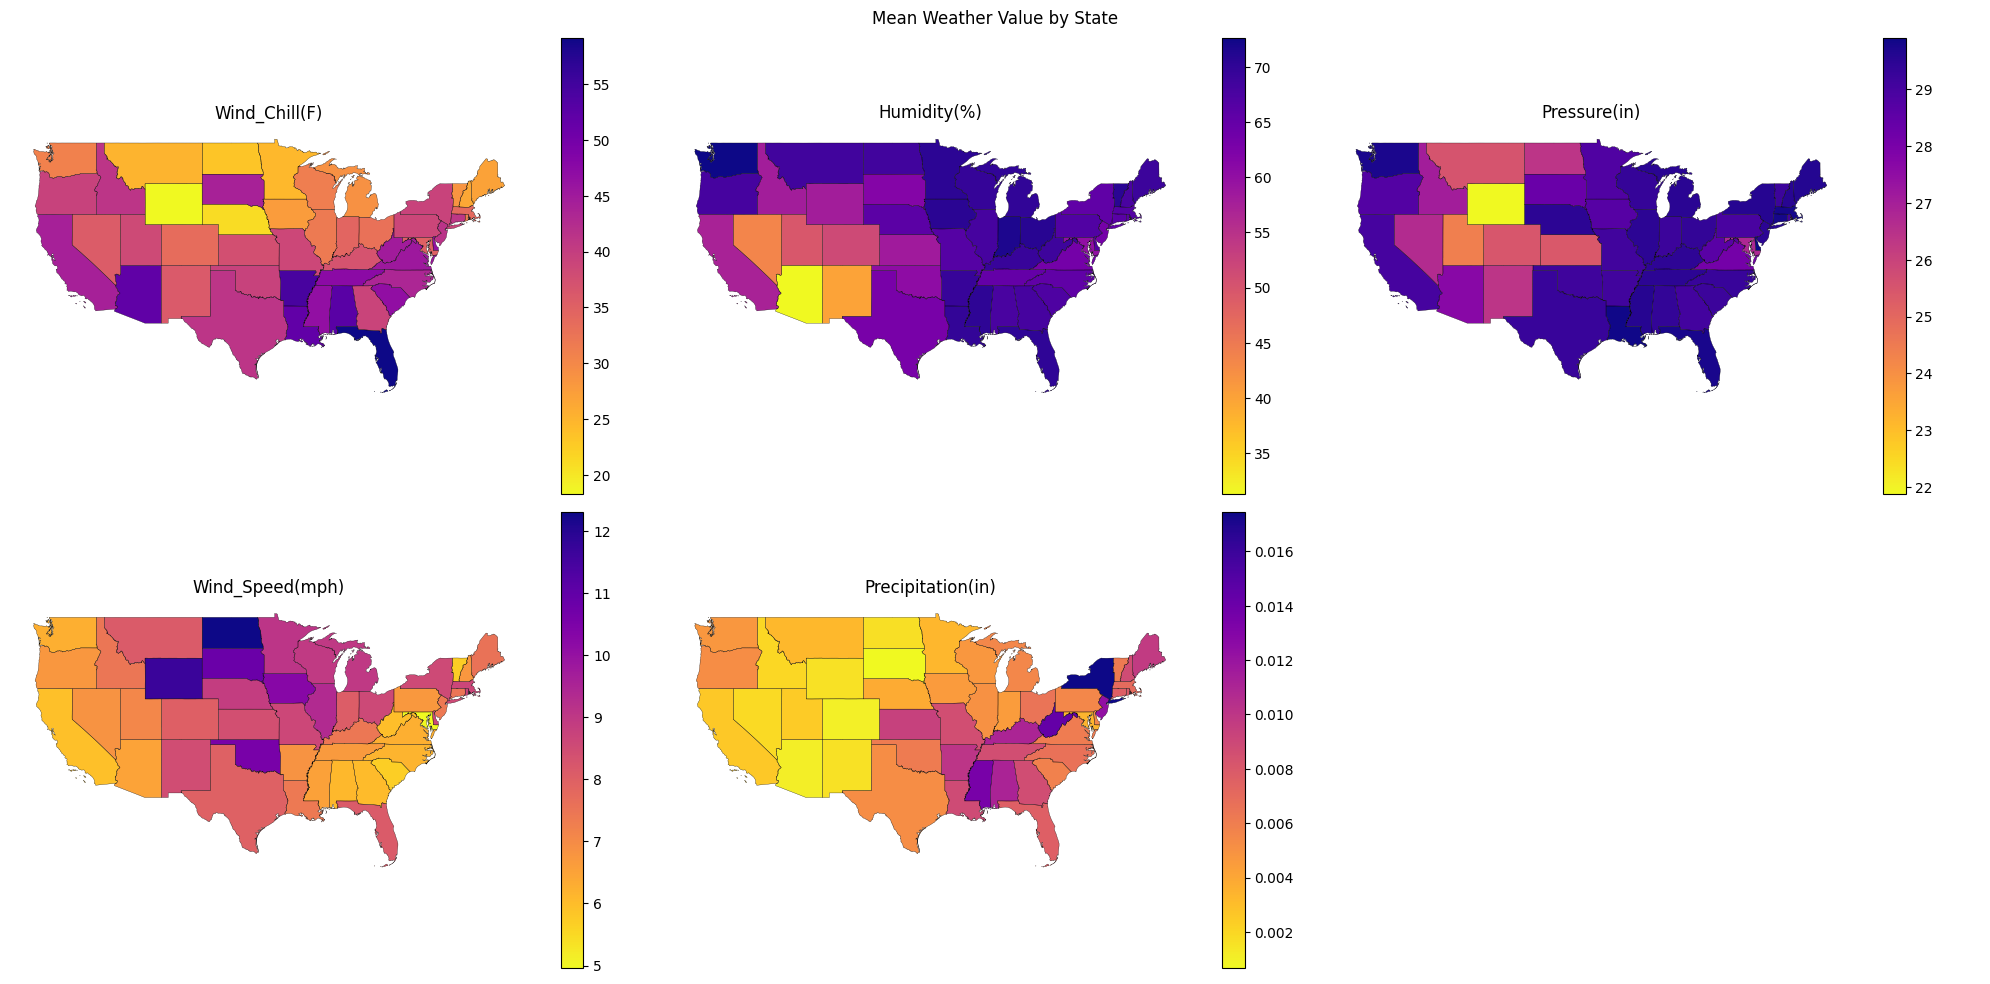

In [20]:
weather_conditions = ['Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                      'Wind_Speed(mph)', 'Precipitation(in)']

fig , axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(weather_conditions):
    
    means_by_state = accident_data.groupby("STATEFP")[feature].mean().reset_index().rename(columns={feature: "means"})
    print(means_by_state)

    geographic_data = gpd.GeoDataFrame(means_by_state.merge(state_data, on='STATEFP'), geometry='geometry')
    print(geographic_data.columns)

    state_data.to_crs("5071")
    state_data.boundary.plot(linewidth=0.2, color='black', ax=axes[i])
    im = geographic_data.plot(column='means', legend=True, cmap='plasma_r', ax=axes[i], label='Mean Weather Condition')
    axes[i].set_title(feature)
    axes[i].set_axis_off()

axes[5].set_axis_off()

plt.suptitle("Mean Weather Value by State")
plt.tight_layout()
plt.savefig("figures/mean_weather_per_state")